** 1. Load Data **

In [1]:
from pandas import Series, DataFrame
import pandas as pd
stocks = ['AAPL', 'AMZN', 'FB', 'GOOG', 'MSFT']
market = 'NASDAQ'
df = pd.read_csv("data/{}.csv".format(market), index_col='Date', 
                         parse_dates=True, usecols=['Date', 'Adj Close'], 
                         na_values =['nan'])
df = df.rename(columns={'Adj Close':market})
for stock in stocks:
    df_temp = pd.read_csv("data/{}.csv".format(stock), index_col='Date', 
                         parse_dates=True, usecols=['Date', 'Adj Close'], 
                         na_values =['nan'])
    df_temp = df_temp.rename(columns={'Adj Close':stock})
    df = df.join(df_temp)

print(df.shape)
df.head()

(504, 6)


,NASDAQ,AAPL,AMZN,FB,GOOG,MSFT
Date,,,,,,
2016-02-04,4509.560059,93.506599,536.260010,110.489998,708.010010,49.505825
2016-02-05,4363.140137,91.009224,502.130005,104.070000,683.570007,47.754078
2016-02-08,4283.750000,91.967522,488.100006,99.750000,682.739990,47.040047
2016-02-09,4268.759766,91.948151,482.070007,99.540001,678.109985,46.916283
2016-02-10,4283.589844,91.251221,490.480011,101.000000,684.119995,47.325657


** 2. Visualize Data **

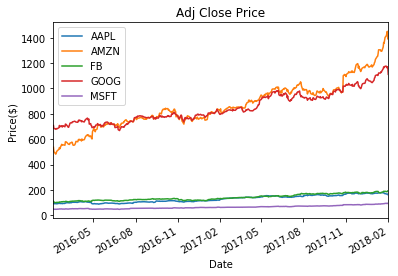

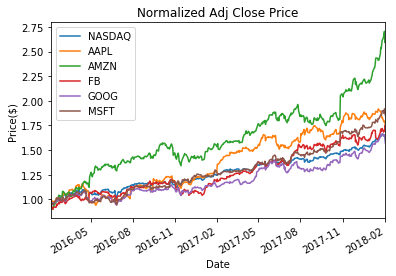

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

p1 = df[stocks].plot(title="Adj Close Price")
p1.set_xlabel("Date")
p1.set_ylabel("Price($)")
plt.show()

df_norm = df / df.iloc[0,:]
p2 = df_norm.plot(title="Normalized Adj Close Price")
p2.set_xlabel("Date")
p2.set_ylabel("Price($)")
plt.show()

** 3. Check for any missing data **

In [3]:
df.isnull().values.ravel().sum()

0

** 4. Create Features **

In [4]:
def cat(a,t):
    b = pd.DataFrame.copy(a)
    b[b >= t] = 1
    b[b <  t] = 0
    return b

In [5]:
def get_rolling_mean(data, window):
    return data.rolling(window=window,center=False).mean()

def get_rolling_std(data, window):
    return data.rolling(window=window,center=False).std()

def get_bollinger_bands(data, window):
    rm = get_rolling_mean(data, window)
    rstd = get_rolling_std(data, window)
    upper_band = rm + 2 * rstd
    lower_band = rm - 2 * rstd
    return rm, upper_band, lower_band, rstd

rm, ub, lb, rstd = get_bollinger_bands(df_norm, 20)

# above bollinger band or below bollinger band
ab = df_norm-ub
ab_ind = cat(ab,0)

bb = df_norm-lb
bb_ind = cat(bb,0)

# deviation from rolling mean
drm = df_norm - rm

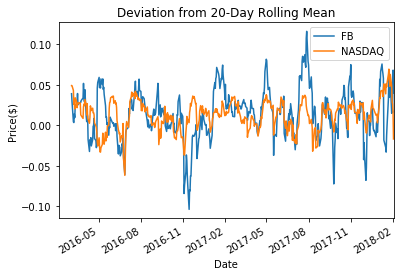

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

p3 = drm[['FB','NASDAQ']].plot(title="Deviation from 20-Day Rolling Mean")
p3.set_xlabel("Date")
p3.set_ylabel("Price($)")
plt.show()

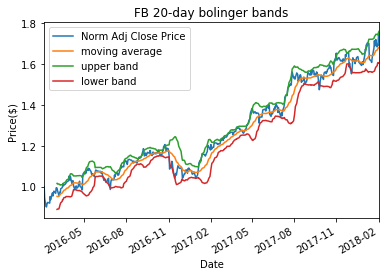

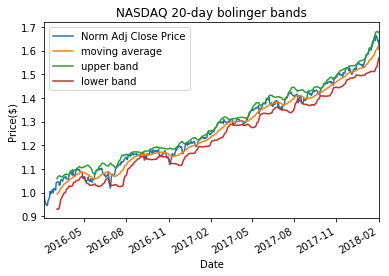

In [7]:
def plot_bollinger_bands(stock, window):
    p = df_norm[stock].plot(title=stock + ' ' + str(window) + '-day bolinger bands', 
                            label="Norm Adj Close Price")
    rm, ub, lb, rstd = get_bollinger_bands(df_norm[stock], window)
    rm.plot(label="moving average", ax = p)
    ub.plot(label="upper band", ax = p)
    lb.plot(label="lower band", ax = p)
    p.set_ylabel("Price($)")
    p.legend(loc='upper left')
    plt.show()

plot_bollinger_bands('FB', 20)
plot_bollinger_bands(market, 20)

In [8]:
def get_daily_return(data):
    daily_return = data / data.shift(1) - 1
    daily_return.iloc[0,:] = 0
    return daily_return
dr = get_daily_return(df_norm)
dr_ind = cat(dr,0)
dr.head()

,NASDAQ,AAPL,AMZN,FB,GOOG,MSFT
Date,,,,,,
2016-02-04,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2016-02-05,-0.032469,-0.026708,-0.063645,-0.058105,-0.034519,-0.035385
2016-02-08,-0.018196,0.010530,-0.027941,-0.041511,-0.001214,-0.014952
2016-02-09,-0.003499,-0.000211,-0.012354,-0.002105,-0.006782,-0.002631
2016-02-10,0.003474,-0.007580,0.017446,0.014667,0.008863,0.008726


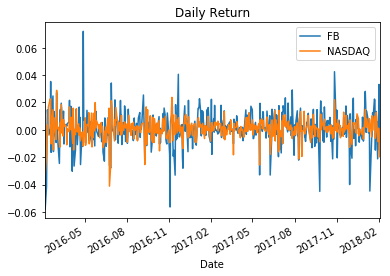

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

p3 = dr[['FB','NASDAQ']].plot(title="Daily Return")
p3.set_xlabel("Date")
plt.show()

In [10]:
import numpy as np
def get_sharp_ratio(data, window):
    return np.sqrt(252) * get_rolling_mean(data, window) / get_rolling_std(data, window)
sr = get_sharp_ratio(df_norm, 60)
sr.tail()

,NASDAQ,AAPL,AMZN,FB,GOOG,MSFT
Date,,,,,,
2018-01-29,490.489969,948.646967,241.440767,693.355303,348.639050,437.238941
2018-01-30,482.815705,956.979857,228.527759,680.760704,340.041882,425.067870
2018-01-31,476.234520,956.139328,217.673939,669.987639,331.528561,402.769066
2018-02-01,470.535722,932.149190,213.594009,629.781853,324.171594,387.919801
2018-02-02,471.019054,819.374917,206.917673,609.819297,325.329971,382.777345


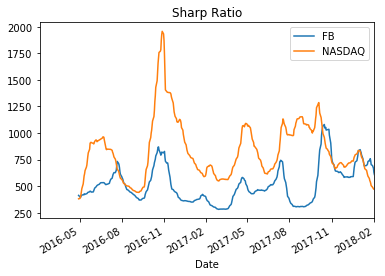

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

p3 = sr[['FB','NASDAQ']].plot(title="Sharp Ratio")
p3.set_xlabel("Date")
plt.show()

In [12]:
def get_momentum(data, window):
    momentum =  data / data.shift(window) - 1
    momentum.iloc[:window-1,:] = 0
    return momentum
mt = get_momentum(df_norm, 5)
mt.tail()

,NASDAQ,AAPL,AMZN,FB,GOOG,MSFT
Date,,,,,,
2018-01-29,0.007894,-0.051073,0.068085,0.003291,0.017105,0.025216
2018-01-30,-0.007749,-0.056880,0.055250,-0.011777,-0.005368,0.009140
2018-01-31,-0.000483,-0.038974,0.068788,0.001823,0.004896,0.034742
2018-02-01,-0.003414,-0.019461,0.008745,0.029923,-0.002281,0.020903
2018-02-02,-0.035282,-0.064194,0.019899,0.001474,-0.054378,-0.024240


In [13]:
rm_mt = get_momentum(rm, 5)
rm_mt.tail()

,NASDAQ,AAPL,AMZN,FB,GOOG,MSFT
Date,,,,,,
2018-01-29,0.017604,-0.000123,0.041612,0.014636,0.026416,0.020642
2018-01-30,0.017572,-0.001352,0.044530,0.014248,0.026786,0.021022
2018-01-31,0.017164,-0.002510,0.047090,0.013150,0.026697,0.022504
2018-02-01,0.016033,-0.003939,0.046108,0.012271,0.025281,0.022969
2018-02-02,0.013177,-0.007786,0.045734,0.010482,0.020616,0.020795


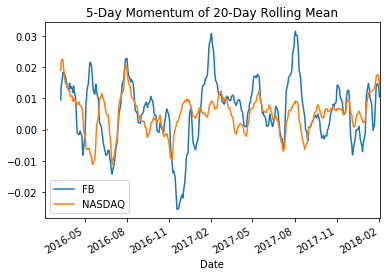

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline

p3 = rm_mt[['FB','NASDAQ']].plot(title="5-Day Momentum of 20-Day Rolling Mean")
p3.set_xlabel("Date")
plt.show()

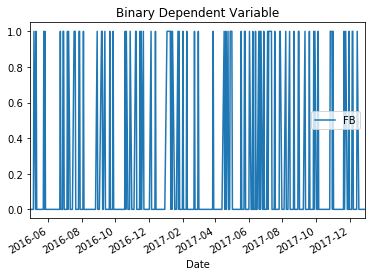

Number of days with 1+ percent increase: 87
Number of days in the data: 422


In [15]:
y = cat(dr,0.01)
import matplotlib.pyplot as plt
%matplotlib inline

p3 = y[['FB']].loc['2016-04-29':'2017-12-29'].plot(title="Binary Dependent Variable")
p3.set_xlabel("Date")
plt.show()

print("Number of days with 1+ percent increase: %d" % y[['FB']].loc['2016-04-29':'2017-12-29'].sum())
print("Number of days in the data: %d" % len(y[['FB']].loc['2016-04-29':'2017-12-29']))

** 5. Prepare Data **

In [16]:
def get_data(stock):
    data = pd.concat([df_norm[stock], drm[stock], ab[stock], bb[stock], 
                      sr[stock], dr[stock], rm_mt[stock], drm[market]], axis=1)
    data.columns = ['norm price','price - rm', 'price - ub', 'price - lb', 
                    'sharp ratio', 'daily return', 
                    'rm momentum', 'market - market_rm']
    return data
X = {stock: get_data(stock) for stock in stocks}

In [41]:
stock = 'FB'

X_train = X[stock].loc['2016-04-29':'2017-08-31']
X_test  = X[stock].loc['2017-09-01':'2017-12-29']
X_train = X_train.reset_index(drop=True)
X_test  = X_test.reset_index(drop=True)

# continuous label
y_train = df_norm.loc['2016-05-02':'2017-09-01', stock]
y_test  = df_norm.loc['2017-09-05':'2018-01-02', stock]
y_train = y_train.reset_index(drop=True)
y_test  = y_test.reset_index(drop=True)

# categorical label
y_train2 = y_train / X_train['norm price'] - 1
y_test2  = y_test / X_test['norm price'] - 1

y_train2 = np.asarray(cat(y_train2,0.01))
y_test2 = np.asarray(cat(y_test2,0.01))

g0 = X_test['norm price'][0]


In [42]:
#np.unique(y_train2, return_counts=True)
np.unique(y_test2, return_counts=True)

(array([ 0.,  1.]), array([68, 15], dtype=int64))

**** Descriptive Analysis ****

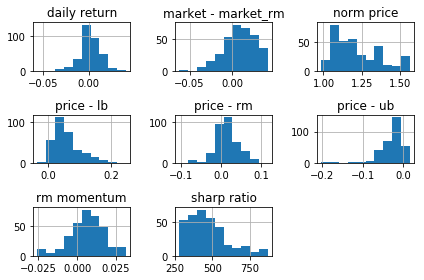

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline
X_train.hist()
plt.tight_layout()

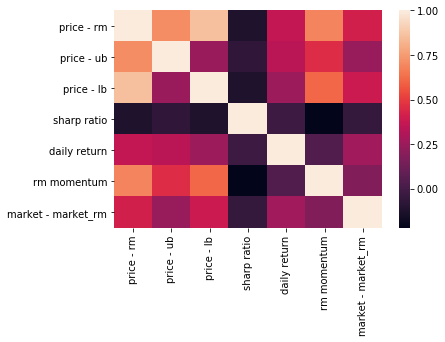

In [20]:
import seaborn as sns
%matplotlib inline

X_train = X_train.drop('norm price', axis=1)
X_test = X_test.drop('norm price', axis=1)

sns.heatmap(X_train.corr())

** Metrics - Net Gain **

In [21]:
# get net gain if make purchase decision based on the predicted closing price 
# at the begining of every day (buy if predict 1 and sell if predict 0)

def get_gain(y0,y_test,y_pred):
    gain = 0
    for i in range(len(y_test)):
        if i == 0:
            if y_pred[i] == 1:
                gain = y_test[i] - y0
        else:
            if y_pred[i] == 1:
                gain += y_test[i] - y_test[i-1]
    return gain

** Naive (Baseline) Prediction **

In [22]:
# predict all 1
y_pred_1 = np.asarray([1 for i in range(len(y_test))])
gain_pred_1 = get_gain(g0, y_test, y_pred_1)
print("Net gain if buy every day: %.4f" % gain_pred_1)
print("Validate answer: %.4f" % (y_test[82] - g0))

Net gain if buy every day: 0.0851
Validate answer: 0.0851


In [23]:
# predict all 0
y_pred_0 = np.asarray([0 for i in range(len(y_test))])
gain_pred_0 = get_gain(g0, y_test, y_pred_0)
print("Net gain if not buy any day: %.4f" % gain_pred_0)

Net gain if not buy any day: 0.0000


** Logistic Regression **

In [24]:
from sklearn import linear_model
from sklearn.metrics import accuracy_score, fbeta_score, precision_score, recall_score, roc_auc_score
lr = linear_model.LogisticRegression()
lr.fit(X_train, y_train2)
y_pred = lr.predict(X_test)

results_lr = {}
results_lr['accuracy'] = accuracy_score(y_test2, y_pred)
results_lr['precision'] = precision_score(y_test2, y_pred)
results_lr['recall'] = recall_score(y_test2, y_pred)
results_lr['auc'] = roc_auc_score(y_test2, y_pred)
results_lr['gain'] = get_gain(g0, y_test, y_pred)


C:\Users\weife\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [27]:
print("Accuracy on test data: %.2f" % results_lr['accuracy'])
print("Precision on test data: %.2f" % results_lr['precision'])
print("Recall on test data: %.2f" % results_lr['recall'])
print("Area under ROC curve on test data: %.2f" % results_lr['auc'])
print("Net gain (normalized): %.2f" % results_lr['gain'])

Accuracy on test data: 0.82
Precision on test data: 0.00
Recall on test data: 0.00
Area under ROC curve on test data: 0.50
Net gain (normalized): 0.00


** SVM **

In [31]:
from sklearn.svm import SVC
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import make_scorer, accuracy_score, fbeta_score, precision_score, recall_score, roc_auc_score

parameters = {'kernel':['rbf'], 'C':[1,5,10]}
clf = SVC(random_state = 0)

scorers = {'accuracy': make_scorer(accuracy_score),
           'fbeta_score: 0.5': make_scorer(fbeta_score, beta=0.5),
           'fbeta_score: 2.0': make_scorer(fbeta_score, beta=2.0)}

results_svm = {}
for key, scorer in scorers.items():
    
    # Time series cross validation sets
    cv_sets = TimeSeriesSplit(n_splits = 10).split(X_train)
    
    results_svm[key] = {}
    
    grid_obj = GridSearchCV(estimator=clf, param_grid=parameters, scoring=scorer, cv=cv_sets)
    grid_fit = grid_obj.fit(X_train, y_train2)
    best_clf = grid_fit.best_estimator_
    y_pred = best_clf.predict(X_test)
    
    results_svm[key]['best_clf'] = best_clf
    results_svm[key]['accuracy'] = accuracy_score(y_test2, y_pred)
    results_svm[key]['precision'] = precision_score(y_test2, y_pred)
    results_svm[key]['recall'] = recall_score(y_test2, y_pred)
    results_svm[key]['auc'] = roc_auc_score(y_test2, y_pred)
    results_svm[key]['gain'] = get_gain(g0, y_test, y_pred)
    results_svm[key]['best_param'] = grid_fit.best_params_


C:\Users\weife\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\weife\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\weife\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\weife\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\weife\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: Undefined

In [32]:
for key, scorer in results_svm.items():
    print(key)
    print("\n")
    print("Accuracy on test data: %.2f" % scorer['accuracy'])
    print("Precision on test data: %.2f" % scorer['precision'])
    print("Recall on test data: %.2f" % scorer['recall'])
    print("Area under ROC curve on test data: %.2f" % scorer['auc'])
    print("Net gain (normalized): %.2f" % scorer['gain'])
    print("Best parameters:")
    print(scorer['best_param'])
    print("\n")


accuracy


Accuracy on test data: 0.71
Precision on test data: 0.09
Recall on test data: 0.07
Area under ROC curve on test data: 0.46
Net gain (normalized): -0.02
Best parameters:
{'C': 1, 'kernel': 'rbf'}


fbeta_score: 0.5


Accuracy on test data: 0.63
Precision on test data: 0.10
Recall on test data: 0.13
Area under ROC curve on test data: 0.43
Net gain (normalized): -0.08
Best parameters:
{'C': 5, 'kernel': 'rbf'}


fbeta_score: 2.0


Accuracy on test data: 0.63
Precision on test data: 0.10
Recall on test data: 0.13
Area under ROC curve on test data: 0.43
Net gain (normalized): -0.08
Best parameters:
{'C': 5, 'kernel': 'rbf'}




** XGBoost and GBM **

In [33]:
import xgboost
from sklearn import ensemble, cross_validation, model_selection
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import accuracy_score, fbeta_score, precision_score, recall_score, roc_auc_score

# classifiers
xgb = xgboost.XGBClassifier(random_state = 0)
gbm = ensemble.GradientBoostingClassifier(random_state = 0)

# parameters
parameters = {'learning_rate': [0.1, 0.2, 0.3], 
              'n_estimators': [200, 300, 500], 
              'max_depth': [2, 3, 4]}

# scorers
scorers = {'accuracy': make_scorer(accuracy_score),
           'fbeta_score: 0.5': make_scorer(fbeta_score, beta=0.5),
           'fbeta_score: 2.0': make_scorer(fbeta_score, beta=2.0)}

# model fit and select
results = {}
for clf in [xgb, gbm]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for key, scorer in scorers.items():
        
        # Time series cross validation sets
        cv_sets = TimeSeriesSplit(n_splits = 10).split(X_train)
        
        results[clf_name][key] = {}
        
        grid_obj = GridSearchCV(estimator=clf, param_grid=parameters, scoring=scorer, cv=cv_sets)
        grid_fit = grid_obj.fit(X_train, y_train2)
        best_clf = grid_fit.best_estimator_
        y_pred = best_clf.predict(X_test)
        
        results[clf_name][key]['best_clf'] = best_clf
        results[clf_name][key]['accuracy'] = accuracy_score(y_test2, y_pred)
        results[clf_name][key]['precision'] = precision_score(y_test2, y_pred)
        results[clf_name][key]['recall'] = recall_score(y_test2, y_pred)
        results[clf_name][key]['auc'] = roc_auc_score(y_test2, y_pred)
        results[clf_name][key]['gain'] = get_gain(g0, y_test, y_pred)
        results[clf_name][key]['best_param'] = grid_fit.best_params_
        

C:\Users\weife\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\weife\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\weife\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\weife\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score

C:\Users\weife\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\weife\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\weife\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\weife\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\weife\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: Undefined

C:\Users\weife\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\weife\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\weife\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\weife\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\weife\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: Undefined

C:\Users\weife\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\weife\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\weife\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\weife\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\weife\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: Undefined

In [34]:
for key, clf in results.items():
    print(key)
    print("\n")
    for key, scorer in clf.items():
        print(key)
        print("Accuracy on test data: %.2f" % scorer['accuracy'])
        print("Precision on test data: %.2f" % scorer['precision'])
        print("Recall on test data: %.2f" % scorer['recall'])
        print("Area under ROC curve on test data: %.2f" % scorer['auc'])
        print("Net gain (normalized): %.2f" % scorer['gain'])
        print("Best parameters:")
        print(scorer['best_param'])
        print("\n")

XGBClassifier


accuracy
Accuracy on test data: 0.55
Precision on test data: 0.13
Recall on test data: 0.27
Area under ROC curve on test data: 0.44
Net gain (normalized): 0.11
Best parameters:
{'learning_rate': 0.2, 'max_depth': 4, 'n_estimators': 200}


fbeta_score: 0.5
Accuracy on test data: 0.58
Precision on test data: 0.21
Recall on test data: 0.47
Area under ROC curve on test data: 0.53
Net gain (normalized): 0.17
Best parameters:
{'learning_rate': 0.3, 'max_depth': 2, 'n_estimators': 500}


fbeta_score: 2.0
Accuracy on test data: 0.58
Precision on test data: 0.21
Recall on test data: 0.47
Area under ROC curve on test data: 0.53
Net gain (normalized): 0.17
Best parameters:
{'learning_rate': 0.3, 'max_depth': 2, 'n_estimators': 500}


GradientBoostingClassifier


accuracy
Accuracy on test data: 0.57
Precision on test data: 0.11
Recall on test data: 0.20
Area under ROC curve on test data: 0.42
Net gain (normalized): 0.15
Best parameters:
{'learning_rate': 0.1, 'max_depth': 4, 'n_est

In [45]:
X2_test  = X[stock].loc['2017-09-29':'2018-02-01']
X2_test  = X2_test.reset_index(drop=True)

y2_test  = df_norm.loc['2017-10-02':'2018-02-02', stock]
y2_test  = y2_test.reset_index(drop=True)

y2_test2 = y2_test / X2_test['norm price'] - 1
y2_test2 = np.asarray(cat(y2_test2,0.01))

g2 = X2_test['norm price'][0]

X2_test = X2_test.drop('norm price', axis=1)

In [52]:
y_pred = lr.predict(X2_test)

results2_lr = {}
results2_lr['accuracy'] = accuracy_score(y2_test2, y_pred)
results2_lr['precision'] = precision_score(y2_test2, y_pred)
results2_lr['recall'] = recall_score(y2_test2, y_pred)
results2_lr['auc'] = roc_auc_score(y2_test2, y_pred)
results2_lr['gain'] = get_gain(g2, y2_test, y_pred)

print("Logistic Regression: \n")
print("Accuracy on test data: %.2f" % results2_lr['accuracy'])
print("Precision on test data: %.2f" % results2_lr['precision'])
print("Recall on test data: %.2f" % results2_lr['recall'])
print("Area under ROC curve on test data: %.2f" % results2_lr['auc'])
print("Net gain (normalized): %.2f" % results2_lr['gain'])

print("\nSVM: \n")
results2_svm = results_svm
for key in results_svm.keys():
    print(key)
    y_pred = results2_svm[key]['best_clf'].predict(X2_test)
    results2_svm[key]['accuracy'] = accuracy_score(y2_test2, y_pred)
    results2_svm[key]['precision'] = precision_score(y2_test2, y_pred)
    results2_svm[key]['recall'] = recall_score(y2_test2, y_pred)
    results2_svm[key]['auc'] = roc_auc_score(y2_test2, y_pred)
    results2_svm[key]['gain'] = get_gain(g2, y2_test, y_pred)
    print("Accuracy on test data: %.2f" % results2_svm[key]['accuracy'])
    print("Precision on test data: %.2f" % results2_svm[key]['precision'])
    print("Recall on test data: %.2f" % results2_svm[key]['recall'])
    print("Area under ROC curve on test data: %.2f" % results2_svm[key]['auc'])
    print("Net gain (normalized): %.2f" % results2_svm[key]['gain'])
    print("Best parameters:")
    print(results_svm[key]['best_param'])
    print("\n")
    
results2 = results
for clf in results.keys():
    print(clf)
    print("\n")
    for key in results[clf].keys():
        print(key)
        y_pred = results2[clf][key]['best_clf'].predict(X2_test)
        results2[clf][key]['accuracy'] = accuracy_score(y2_test2, y_pred)
        results2[clf][key]['precision'] = precision_score(y2_test2, y_pred)
        results2[clf][key]['recall'] = recall_score(y2_test2, y_pred)
        results2[clf][key]['auc'] = roc_auc_score(y2_test2, y_pred)
        results2[clf][key]['gain'] = get_gain(g2, y2_test, y_pred)
        print("Accuracy on test data: %.2f" % results2[clf][key]['accuracy'])
        print("Precision on test data: %.2f" % results2[clf][key]['precision'])
        print("Recall on test data: %.2f" % results2[clf][key]['recall'])
        print("Area under ROC curve on test data: %.2f" % results2[clf][key]['auc'])
        print("Net gain (normalized): %.2f" % results2[clf][key]['gain'])
        print("Best parameters:")
        print(results[clf][key]['best_param'])
        print("\n")

Logistic Regression: 

Accuracy on test data: 0.79
Precision on test data: 0.00
Recall on test data: 0.00
Area under ROC curve on test data: 0.50
Net gain (normalized): 0.00

SVM: 

accuracy
Accuracy on test data: 0.70
Precision on test data: 0.17
Recall on test data: 0.11
Area under ROC curve on test data: 0.48
Net gain (normalized): -0.02
Best parameters:
{'C': 1, 'kernel': 'rbf'}


fbeta_score: 0.5
Accuracy on test data: 0.62
Precision on test data: 0.14
Recall on test data: 0.17
Area under ROC curve on test data: 0.45
Net gain (normalized): -0.14
Best parameters:
{'C': 5, 'kernel': 'rbf'}


fbeta_score: 2.0
Accuracy on test data: 0.62
Precision on test data: 0.14
Recall on test data: 0.17
Area under ROC curve on test data: 0.45
Net gain (normalized): -0.14
Best parameters:
{'C': 5, 'kernel': 'rbf'}


XGBClassifier


accuracy
Accuracy on test data: 0.56
Precision on test data: 0.17
Recall on test data: 0.28
Area under ROC curve on test data: 0.46
Net gain (normalized): 0.06
Best par

C:\Users\weife\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
